In [42]:
import json
import tabulate
import evaluation

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Origin", "Faulty engine", "Code Size", "Function Count"]

for test_name, data in metrics.items():
    metadata = data['metadata']
    table_data.append([
        test_name,
        metadata['origin'],
        metadata['engine'],
        data['rq2']['original-size-code'],
        metadata['function_count']
    ])
# Sort the table data by the original size code
table_data.sort(key=lambda row: row[3] if isinstance(row[3], (int, float)) else float('inf'))

# Generate the LaTeX table
latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw")

# Modify the LaTeX table string
latex_table = latex_table.replace("#", "\\#")

# Save the table to a file
rq1_table_path = f'{evaluation.PAPER_PATH}/table/eval_set.tex'
with open(rq1_table_path, 'w') as file:
    file.write(latex_table)
    print(f"Table saved to {rq1_table_path}")

KeyError: 'metadata'

In [49]:
import json
from numpy import average
import tabulate
import evaluation

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Sort the metrics by key
metrics = dict(sorted(metrics.items()))
del metrics['rq4']

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Target", "Success", "Size Reduced", "Split Time(s)", "RR Time(s)"]

for test_name, data in metrics.items():
    metadata = data['metadata']
    target_function_count = len(data['rq1'])
    split_time = average([obj['split-time'] / 1000 for obj in data['rq1'].values()])
    rr_time_values = [obj['rr-time'] / 1000 for obj in data['rq1'].values() if obj['rr-time'] != 'fail']
    rr_time = average(rr_time_values) if rr_time_values else 'N/A'
    # rr_did_timeout = sum(1 for obj in data['rq1'].values() if obj['rr-did-timeout'] == True)
    try:
        rr_success = sum(1 for obj in data['rq1'].values() if obj['sliced_file_size'] != 'fail')
    except:
        raise Exception(f"Error in {test_name}")
    rr_reduction_rate_values = [obj['sliced_code_size'] / metadata['code_size'] * 100 for obj in data['rq1'].values() if obj['sliced_file_size'] != 'fail']
    rr_reduction_rate = f"{average(rr_reduction_rate_values):.2f}%" if rr_reduction_rate_values else 'N/A'
    table_data.append([
        test_name,
        target_function_count,
        rr_success,
        rr_reduction_rate,
        split_time,
        rr_time,
    ])

# Sort the table data by the original size code
table_data.sort(key=lambda row: metrics[row[0]]['rq2']['original-size-code'])

# Calculate the sum of all the rows
sum_target_function_count = sum(row[1] for row in table_data)
sum_rr_success = sum(row[2] for row in table_data)

average_split_time = average([obj['split-time'] / 1000 for data in metrics.values() for obj in data['rq1'].values()])
total_rr_time_values = [obj['rr-time'] / 1000 for data in metrics.values() for obj in data['rq1'].values() if obj['rr-time'] != 'fail']
average_rr_time = average(total_rr_time_values) if total_rr_time_values else 'N/A'
total_rr_reduction_rate_values = [obj['sliced_code_size'] / data['metadata']['code_size'] * 100 for data in metrics.values() for obj in data['rq1'].values() if obj['sliced_file_size'] != 'fail']
average_rr_reduction_rate = f"{average(total_rr_reduction_rate_values):.2f}%" if total_rr_reduction_rate_values else 'N/A'

# Append the total row to the table data
table_data.append([
    "Sum",
    sum_target_function_count,
    sum_rr_success,
])

table_data.append([
    'Average',
    '',
    '',
    average_rr_reduction_rate,
    average_split_time,
    average_rr_time,
])

for row in table_data:
    for i, cell in enumerate(row):
        if isinstance(cell, float):
            row[i] = f"{cell:.2f}"

# Generate the LaTeX table
latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw", floatfmt=".2f")

# Modify the LaTeX table string
latex_table = latex_table.replace("#", "\\#")
latex_table = latex_table.replace("%", "\\%")

# Add distinction for the total row
latex_table = latex_table.replace("Sum", "\\hline\nSum")

# Save the table to a file
rq1_table_path = f'{evaluation.PAPER_PATH}/table/rq1.tex'
with open(rq1_table_path, 'w') as file:
    file.write(latex_table)
    print(latex_table)
    print(f"Table saved to {rq1_table_path}")

\begin{tabular}{llllrr}
\hline
 Name          & Target   & Success   & Size Reduced   &   Split Time(s) &   RR Time(s) \\
\hline
 wamr\#2861     & 1        & 1         & 102.08\%        &            0.03 &         1.86 \\
 wasmedge\#3018 & 12       & 12        & 14.35\%         &            0.03 &        60.34 \\
 wamr\#2789     & 58       & 56        & 3.50\%          &            0.05 &        66.69 \\
 wasmedge\#3019 & 76       & 76        & 3.60\%          &            0.06 &        60.34 \\
 wamr\#2862     & 73       & 73        & 3.65\%          &            0.06 &         2.30 \\
 wamr\#2450     & 66       & 66        & 2.97\%          &            0.06 &         2.27 \\
 wasmedge\#3076 & 131      & 131       & 517.60\%        &            0.08 &        60.30 \\
 mandelbrot    & 167      & 167       & 153.87\%        &            0.14 &        40.09 \\
 wasmedge\#3057 & 1000     & 1000      & 2.44\%          &            0.32 &       116.72 \\
 guiicons      & 505      & 505    

In [45]:
# Where extracted is larger than
cases = []
for test_name, data in metrics.items():
    for fidx, obj in data['rq1'].items():
        if obj['sliced_file_size'] != 'fail' and obj['sliced_code_size'] > data['metadata']['code_size']:
            cases.append(f"{test_name}-{fidx}")

# Sort the cases
cases.sort()

# # Print the sorted cases
# for case in cases:
#     print(case)

print(f"Total number of cases where sliced_file_size is greater than metadata size: {len(cases)}")

Total number of cases where sliced_file_size is greater than metadata size: 80


Split Time Regression Statistics:
Slope: 0.000001
Intercept: 0.046790
R-squared: 0.992475
P-value: 0.000000
Standard Error: 0.000000

RR Time Regression Statistics:
Slope: -0.000001
Intercept: 31.283674
R-squared: 0.000913
P-value: 0.896570
Standard Error: 0.000005
Figure saved to /home/don/rr-reduce-paper/issta_2025/figures/rq1-size-time.pdf


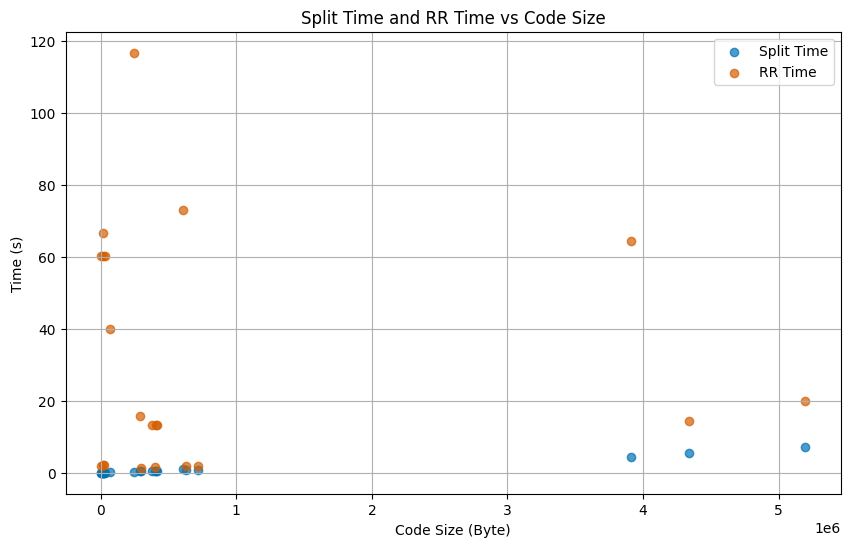

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Function to calculate average, ignoring 'fail' values
def average(lst):
    valid = [x for x in lst if x != 'fail']
    return sum(valid) / len(valid) if valid else 0

# Extract data for plotting
x_data = [data['metadata']['code_size'] for data in metrics.values()]
split_time_data = [average([obj['split-time'] / 1000 for obj in data['rq1'].values()]) for data in metrics.values()]
rr_time_data = [average([obj['rr-time'] / 1000 for obj in data['rq1'].values() if obj['rr-time'] != 'fail']) for data in metrics.values()]

# Convert to numpy arrays
x = np.array(x_data)
y_split = np.array(split_time_data)
y_rr = np.array(rr_time_data)

# Calculate linear regression statistics
slope_split, intercept_split, r_value_split, p_value_split, std_err_split = stats.linregress(x, y_split)
slope_rr, intercept_rr, r_value_rr, p_value_rr, std_err_rr = stats.linregress(x, y_rr)

# Print regression statistics
print("Split Time Regression Statistics:")
print(f"Slope: {slope_split:.6f}")
print(f"Intercept: {intercept_split:.6f}")
print(f"R-squared: {r_value_split**2:.6f}")
print(f"P-value: {p_value_split:.6f}")
print(f"Standard Error: {std_err_split:.6f}")
print()

print("RR Time Regression Statistics:")
print(f"Slope: {slope_rr:.6f}")
print(f"Intercept: {intercept_rr:.6f}")
print(f"R-squared: {r_value_rr**2:.6f}")
print(f"P-value: {p_value_rr:.6f}")
print(f"Standard Error: {std_err_rr:.6f}")

# Plot the data (unchanged from your original code)

color_split = '#0072B2'  # Blue
color_rr = '#D55E00'  # Vermilion
plt.figure(figsize=(10, 6))
plt.scatter(x_data, split_time_data, alpha=0.7, label='Split Time', color=color_split)
plt.scatter(x_data, rr_time_data, alpha=0.7, label='RR Time', color=color_rr)
plt.xlabel('Code Size (Byte)')
plt.ylabel('Time (s)')
plt.title('Split Time and RR Time vs Code Size')
plt.legend()
plt.grid(True)

# Save the figures to a file
fig_path_pdf = f'{evaluation.PAPER_PATH}/figures/rq1-size-time.pdf'
plt.savefig(fig_path_pdf)
print(f"Figure saved to {fig_path_pdf}")

In [2]:
import json
from numpy import average
import tabulate
import evaluation

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Input Size", "RR-Reduce Size",  "RR-Reduce Time(s)", "wasm-reduce Size", "wasm-reduce Time(s)", "wasm-shrink Size", "wasm-shrink Time(s)"]

for test_name, data in metrics.items():
    metadata = data['metadata']
    original_size = data['rq2'].get('original-size-code')
    rr_reduce_size = data['rq2'].get('wasm-slice-size-code')
    rr_reduce_time = data['rq2'].get('wasm-slice-time')
    wasm_reduce_size = data['rq2'].get('wasm-reduce-size-code')
    wasm_reduce_time = data['rq2'].get('wasm-reduce-time')
    wasm_shrink_size = data['rq2'].get('wasm-shrink-size-code')
    wasm_shrink_time = data['rq2'].get('wasm-shrink-time')
    table_data.append([
        test_name,
        original_size,
        rr_reduce_size,
        rr_reduce_time,
        wasm_reduce_size,
        wasm_reduce_time,
        wasm_shrink_size,
        wasm_shrink_time,
    ])

    # Sort the table data by the original size
table_data.sort(key=lambda row: row[1] if isinstance(row[1], (int, float)) else float('inf'))

# Collect where rr-reduce size is bigger than wasm-reduce size and vice versa
rr_bigger = []
wasm_bigger = []


# Calculate the average values
average_original_size = average([row[1] for row in table_data])
average_rr_reduce_size = average([row[2] for row in table_data])
average_rr_reduce_time = average([row[3] for row in table_data])
average_wasm_reduce_size = average([row[4] for row in table_data])
average_wasm_reduce_time = average([row[5] for row in table_data])
average_wasm_shrink_size = average([row[6] for row in table_data])
average_wasm_shrink_time = average([row[7] for row in table_data])
table_data.append([
    "Average",
    average_original_size,
    average_rr_reduce_size,
    average_rr_reduce_time,
    average_wasm_reduce_size,
    average_wasm_reduce_time,
    average_wasm_shrink_size,
    average_wasm_shrink_time,
])


# Generate the LaTeX table
latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw", floatfmt=".0f")

# Replace the single row header with a custom double row header
old_header = r"""\begin{tabular}{lrrrrrrr}
\hline
 Name          &   Input Size &   RR-Reduce Size &   RR-Reduce Time(s) &   wasm-reduce Size &   wasm-reduce Time(s) &   wasm-shrink Size &   wasm-shrink Time(s) \\"""
new_header = r"""\begin{tabular}{lr|rr|rr|rr}
    \hline
    \multicolumn{2}{c|}{} & \multicolumn{2}{c|}{RR-Reduce} & \multicolumn{2}{c|}{wasm-reduce} & \multicolumn{2}{c}{wasm-shrink} \\
    Name & Input Size & Size & Time(s) & Size & Time(s) & Size & Time(s) \\"""

latex_table = latex_table.replace(old_header, new_header)


# Modify the LaTeX table string
latex_table = latex_table.replace("#", "\\#")
latex_table = latex_table.replace("%", "\\%")
# Add distinction for the total row
latex_table = latex_table.replace("Average", "\\hline\n\\textbf{Average}")

# Save the table to a file
rq4_table_path = f'{evaluation.PAPER_PATH}/table/rq3.tex'
with open(rq4_table_path, 'w') as file:
    file.write(latex_table)
    print(latex_table)
    print(f"Table saved to {rq4_table_path}")


\begin{tabular}{lr|rr|rr|rr}
    \hline
    \multicolumn{2}{c|}{} & \multicolumn{2}{c|}{RR-Reduce} & \multicolumn{2}{c|}{wasm-reduce} & \multicolumn{2}{c}{wasm-shrink} \\
    Name & Input Size & Size & Time(s) & Size & Time(s) & Size & Time(s) \\
\hline
 wamr\#2861     &          576 &              576 &                   2 &                 39 &                    32 &                451 &                   134 \\
 wasmedge\#3018 &         1913 &              454 &                 120 &                 24 &                    38 &                162 &                   106 \\
 wamr\#2789     &        17604 &              336 &                 245 &                  9 &                   204 &                  9 &                   104 \\
 wasmedge\#3019 &        19098 &              716 &                 121 &                 12 &                   375 &               1473 &                   190 \\
 wamr\#2862     &        19727 &             1829 &                 182 &             

In [6]:
# Compute average size where original size is less than 100k
table_data_less_than_100k = [row for row in table_data if row[1] < 100000]
average_original_size_less_than_100k = average([row[1] for row in table_data_less_than_100k])
average_rr_reduce_size_less_than_100k = average([row[2] for row in table_data_less_than_100k])
average_wasm_reduce_size_less_than_100k = average([row[4] for row in table_data_less_than_100k])
average_rr_reduce_time_less_than_100k = average([row[3] for row in table_data_less_than_100k])
average_wasm_reduce_time_less_than_100k = average([row[5] for row in table_data_less_than_100k])
print(f"Average Original Size for <100k: {average_original_size_less_than_100k}")
print(f"Average RR-Reduce Size for <100k: {average_rr_reduce_size_less_than_100k}")
print(f"Average wasm-reduce Size for <100k: {average_wasm_reduce_size_less_than_100k}")
print(f"Average RR-Reduce Time for <100k: {average_rr_reduce_time_less_than_100k}")
print(f"Average wasm-reduce Time for <100k: {average_wasm_reduce_time_less_than_100k}")
print('')

# Compute average size where original size is 100k~1mil
table_data_100k_1mil = [row for row in table_data if 100000 <= row[1] <= 1000000]
average_original_size_100k_1mil = average([row[1] for row in table_data_100k_1mil])
average_rr_reduce_size_100k_1mil = average([row[2] for row in table_data_100k_1mil])
average_wasm_reduce_size_100k_1mil = average([row[4] for row in table_data_100k_1mil])
average_rr_reduce_time_100k_1mil = average([row[3] for row in table_data_100k_1mil])
average_wasm_reduce_time_100k_1mil = average([row[5] for row in table_data_100k_1mil])
print(f"Average Original Size for 100k~1mil: {average_original_size_100k_1mil}")
print(f"Average RR-Reduce Size for 100k~1mil: {average_rr_reduce_size_100k_1mil}")
print(f"Average wasm-reduce Size for 100k~1mil: {average_wasm_reduce_size_100k_1mil}")
print(f"Average RR-Reduce Time for 100k~1mil: {average_rr_reduce_time_100k_1mil}")
print(f"Average wasm-reduce Time for 100k~1mil: {average_wasm_reduce_time_100k_1mil}")
print('')

# Compute average size where original size is more than 1 mil
table_data_more_than_1mil = [row for row in table_data if row[1] > 1000000]
average_original_size_more_than_1mil = average([row[1] for row in table_data_more_than_1mil])
average_rr_reduce_size_more_than_1mil = average([row[2] for row in table_data_more_than_1mil])
average_wasm_reduce_size_more_than_1mil = average([row[4] for row in table_data_more_than_1mil])
average_rr_reduce_time_more_than_1mil = average([row[3] for row in table_data_more_than_1mil])
average_wasm_reduce_time_more_than_1mil = average([row[5] for row in table_data_more_than_1mil])
print(f"Average Original Size for >1mil: {average_original_size_more_than_1mil}")
print(f"Average RR-Reduce Size for >1mil: {average_rr_reduce_size_more_than_1mil}")
print(f"Average wasm-reduce Size for >1mil: {average_wasm_reduce_size_more_than_1mil}")
print(f"Average RR-Reduce Time for >1mil: {average_rr_reduce_time_more_than_1mil}")
print(f"Average wasm-reduce Time for >1mil: {average_wasm_reduce_time_more_than_1mil}")
print('')

Average Original Size for <100k: 22410.0
Average RR-Reduce Size for <100k: 12179.25
Average wasm-reduce Size for <100k: 3320.875
Average RR-Reduce Time for <100k: 552.6210693120956
Average wasm-reduce Time for <100k: 621.9950468838215

Average Original Size for 100k~1mil: 476734.73593073594
Average RR-Reduce Size for 100k~1mil: 128976.77489177488
Average wasm-reduce Size for 100k~1mil: 119660.22077922079
Average RR-Reduce Time for 100k~1mil: 455.99872527906905
Average wasm-reduce Time for 100k~1mil: 2657.220136848879

Average Original Size for >1mil: 4484961.333333333
Average RR-Reduce Size for >1mil: 162413.66666666666
Average wasm-reduce Size for >1mil: 3375245.3333333335
Average RR-Reduce Time for >1mil: 1256.7587320804596
Average wasm-reduce Time for >1mil: 3600.0046389102936



In [3]:
import json
from numpy import average
import tabulate
import evaluation

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Input Size", "RR-Reduce Size",  "RR-Reduce Time(s)"]

for test_name, data in metrics['rq4'].items():
    original_size = data.get('original-size-code')
    rr_reduce_size = data.get('wasm-slice-size-code')
    rr_reduce_time = data.get('wasm-slice-time')
    table_data.append([
        test_name,
        original_size,
        rr_reduce_size,
        rr_reduce_time,
    ])

    # Sort the table data by the original size
table_data.sort(key=lambda row: row[1] if isinstance(row[1], (int, float)) else float('inf'))

# Calculate the average values
average_original_size = average([row[1] for row in table_data])
average_rr_reduce_size = average([row[2] for row in table_data])
average_rr_reduce_time = average([row[3] for row in table_data])
table_data.append([
    "Average",
    average_original_size,
    average_rr_reduce_size,
    average_rr_reduce_time,
])


# Generate the LaTeX table
latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw")

# Modify the LaTeX table string
latex_table = latex_table.replace("#", "\\#")
latex_table = latex_table.replace("%", "\\%")
latex_table = latex_table.replace("_", "\_")
# Add distinction for the total row
latex_table = latex_table.replace("Average", "\\hline\n\\textbf{Average}")

# Save the table to a file
rq4_table_path = f'{evaluation.PAPER_PATH}/table/rq4.tex'
with open(rq4_table_path, 'w') as file:
    file.write(latex_table)
    print(latex_table)
    print(f"Table saved to {rq4_table_path}")


\begin{tabular}{lrrr}
\hline
 Name                &   Input Size &   RR-Reduce Size &   RR-Reduce Time(s) \\
\hline
 tcas\_v5\_u1178.wasm  &      13133   &          1109    &             1.92386 \\
 tcas\_v15\_u150.wasm  &      13135   &          1110    &             1.9773  \\
 tcas\_v16\_u1001.wasm &      13135   &          1110    &             1.82659 \\
 tcas\_v1\_u0.wasm     &      13135   &          1110    &             1.84934 \\
 tcas\_v2\_u1182.wasm  &      13135   &          1110    &             2.01658 \\
 tcas\_v3\_u112.wasm   &      13135   &          1110    &             1.99758 \\
 tcas\_v4\_u110.wasm   &      13135   &          1110    &             1.93791 \\
 tcas\_v11\_u1324.wasm &      13141   &          1126    &             1.98099 \\
 tcas\_v10\_u1323.wasm &      13184   &          1169    &             1.98219 \\
 tcas\_v13\_u571.wasm  &      13184   &          1196    &             1.97434 \\
 tcas\_v6\_u1322.wasm  &      13184   &          1169    &      

<>:46: SyntaxWarning: invalid escape sequence '\_'
<>:46: SyntaxWarning: invalid escape sequence '\_'
/tmp/ipykernel_410678/3100022690.py:46: SyntaxWarning: invalid escape sequence '\_'
  latex_table = latex_table.replace("_", "\_")


In [ ]:
!python sanity_check.py